In [1]:
from validphys.api import API
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from validphys.fkparser import load_fktable
from collections import defaultdict

from typing import List, Dict
from collections import namedtuple

from n3fit.layers import DIS

Using Keras backend


In [2]:
# The largest xgrid used NNPDF
XGRID = np.array([2.00000000e-07, 3.03430477e-07, 4.60350147e-07, 6.98420853e-07,
       1.05960950e-06, 1.60758550e-06, 2.43894329e-06, 3.70022721e-06,
       5.61375772e-06, 8.51680668e-06, 1.29210157e-05, 1.96025050e-05,
       2.97384954e-05, 4.51143839e-05, 6.84374492e-05, 1.03811730e-04,
       1.57456056e-04, 2.38787829e-04, 3.62054496e-04, 5.48779532e-04,
       8.31406884e-04, 1.25867971e-03, 1.90346340e-03, 2.87386758e-03,
       4.32850064e-03, 6.49620619e-03, 9.69915957e-03, 1.43750686e-02,
       2.10891867e-02, 3.05215840e-02, 4.34149174e-02, 6.04800288e-02,
       8.22812213e-02, 1.09143757e-01, 1.41120806e-01, 1.78025660e-01,
       2.19504127e-01, 2.65113704e-01, 3.14387401e-01, 3.66875319e-01,
       4.22166775e-01, 4.79898903e-01, 5.39757234e-01, 6.01472198e-01,
       6.64813948e-01, 7.29586844e-01, 7.95624252e-01, 8.62783932e-01,
       9.30944081e-01, 1.00000000e+00])

In [3]:
# List of DIS dataset
dataset_inputs = [
  #{'dataset': 'NMC_NC_NOTFIXED_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'NMC_NC_NOTFIXED_P_EM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'SLAC_NC_NOTFIXED_P_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'SLAC_NC_NOTFIXED_D_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'BCDMS_NC_NOTFIXED_P_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'BCDMS_NC_NOTFIXED_D_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'CHORUS_CC_NOTFIXED_PB_DW_NU-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'CHORUS_CC_NOTFIXED_PB_DW_NB-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'NUTEV_CC_NOTFIXED_FE_DW_NU-SIGMARED', 'cfac': ['MAS'], 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'NUTEV_CC_NOTFIXED_FE_DW_NB-SIGMARED', 'cfac': ['MAS'], 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_318GEV_EM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_225GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_251GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_300GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_318GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_CC_318GEV_EM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_CC_318GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_318GEV_EAVG_CHARM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_318GEV_EAVG_BOTTOM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
]

# Dictionary for validphys API
common_dict = dict(
    dataset_inputs=dataset_inputs,
    metadata_group="nnpdf31_process",
    use_cuts='internal',
    datacuts={'q2min': 3.49, 'w2min': 12.5},
    theoryid=40000000,
    t0pdfset='NNPDF40_nnlo_as_01180',
    use_t0=True
)

In [4]:
groups_data = API.procs_data(**common_dict)
groups_index = API.groups_index(**common_dict)

In [5]:
from validphys.pineparser import pineappl_reader
from n3fit.layers.observable import compute_float_mask
from n3fit.backends import operations as op

# Initialise the dictionaries
fk_table_dict = defaultdict(list)
central_data_dict = {}
padded_fk_dict = defaultdict(list)
xgrid_masks_dict = defaultdict(list)

total_ndata_wc = 0
data_size_dict = defaultdict(list)

for idx_proc, group_proc in enumerate(groups_data):
  for idx_exp, exp_set in enumerate(group_proc.datasets):
    
    dataset_name = exp_set.name
    dataset_size = exp_set.load_commondata().ndata
    total_ndata_wc += dataset_size

    # Collect FKSpecs and cuts
    fkspecs = exp_set.fkspecs
    cuts = exp_set.cuts

    # Read FKData and FK table in numpy version
    fk_data = pineappl_reader(fkspecs[0]).with_cuts(cuts)
    fk_table = fk_data.get_np_fktable()

    # xgrid for this dataset
    xgrid = fk_data.xgrid

    # Check that XGRID is just a small-x extension
    # of xgrid
    res = True
    for i, x in enumerate(xgrid):
      offset = 50 - xgrid.size
      try:
        assert(np.isclose(x, XGRID[offset+i]))
      except AssertionError:
        print(f"XGRID is not an extension for {dataset_name}.")

    # Load DIS object for padding the FK table
    dis = DIS(
      [fk_data],
      [fk_table],
      dataset_name,
      None,
      exp_set.op,
      n_replicas=1,
      name=f"dat_{dataset_name}"
    )
    
    # OLD
    # Pad the fk table so that (N, x, 9) -> (N, x, 14)
    mask = dis.masks[0]
    padded_fk_table = dis.fktables[0]#dis.pad_fk(dis.fktables[0], mask)
    padded_fk_dict[dataset_name] = dis.pad_fk(dis.fktables[0], mask)

    # Extend xgrid to low-x (N, x, 14) -> (N, 50, 14)
    xgrid_mask = np.zeros(XGRID.size, dtype=bool)
    offset = XGRID.size - xgrid.size
    for i in range(xgrid.size):
      xgrid_mask[offset + i] = True
    xgrid_mask = compute_float_mask(xgrid_mask)
    paddedx_fk_table = op.einsum('Xx, nFx -> nXF', xgrid_mask, padded_fk_table)
    xgrid_masks_dict[dataset_name] = xgrid_mask
    # Check the mask in x is applied correctly
    #for i in range(XGRID.size):
    if i >= offset:
      try:
        assert(np.allclose(paddedx_fk_table[:,i,:], padded_fk_table[:,:,i - offset]))
      except AssertionError:
        print(f'Problem in the unchanged values for {dataset_name}')
    else:
      try:
        assert(np.allclose(paddedx_fk_table[:,i,:], np.zeros_like(paddedx_fk_table[:,i,:])))
      except AssertionError:
        print(f'Problem in the extension for {dataset_name}')

    # Save to dict
    fk_table_dict[dataset_name] = paddedx_fk_table
    central_data_dict[dataset_name] = exp_set.load_commondata().with_cuts(cuts).central_values.to_numpy()


In [6]:
# Generate the NNPDF model
from n3fit import model_gen

seed = 124143

flav_info = [{'fl': 'sng',  'trainable': False, 'smallx': [0,0],  'largex': [0,0]}, 
             {'fl': 'g',    'trainable': False, 'smallx': [0,0],  'largex': [0,0]}, 
             {'fl': 'v',    'trainable': False, 'smallx': [0,0],  'largex': [0,0]}, 
             {'fl': 'v3',   'trainable': False, 'smallx': [0,0],  'largex': [0,0]}, 
             {'fl': 'v8',   'trainable': False, 'smallx': [0,0],  'largex': [0,0]}, 
             {'fl': 't3',   'trainable': False, 'smallx': [0,0],  'largex': [0,0]}, 
             {'fl': 't8',   'trainable': False, 'smallx': [0,0],  'largex': [0,0]}, 
             {'fl': 't15',  'trainable': False, 'smallx': [0,0],  'largex': [0,0]}]

# arugments for NNPDF model generation
model_parameters = {
  'nodes' : [25, 20, 8],
  'activations' : ['tanh', 'tanh', 'linear'],
  'layer_type' : 'dense',
  'flav_info' : flav_info,
  'fitbasis' : 'EVOL',
  'seed' : seed,
  'initializer_name' : 'glorot_normal',
  'dropout' : 0.0,
  'regularizer' : None,
  'regularizer_args' : None,
  'impose_sumrule' : True,
  'scaler' : None,
  'num_replicas' : 1,
  'photons' : None
}

pdf_model = model_gen.pdfNN_layer_generator(**model_parameters)

# Training the model using MSE

In [103]:
# Load a PDF set and convolute the central member with
# the FK table. Then, compare the result with the central
# data
from n3fit.layers import FlavourToEvolution, FkRotation
from n3fit.backends import operations as op

flavour_map = [
        {'fl': 'u'},
        {'fl': 'ubar'},
        {'fl': 'd'},
        {'fl': 'dbar'},
        {'fl': 's'},
        {'fl': 'sbar'},
        {'fl': 'c'},
        {'fl': 'g'},
    ]

# Flavour and Evolution info for rotation matrix
PID_map = {
  'd'    : 1,
  'u'    : 2,
  's'    : 3,
  'c'    : 4,
  'b'    : 5,
  'dbar' : -1,
  'ubar' : -2,
  'sbar' : -3,
  'cbar' : -4,
  'bbar' : -5,
  'g'    : 21
}

NN31IC_ev_basis = {
  0: r"$\Sigma$",
  1: r"$g$",
  2: r"$V$",
  3: r"$V_3$",
  4: r"$V_8$",
  5: r"$T_3$",
  6: r"$T_8$",
  7: r"$c^+$",
  8: r"$V_{15}$"
}

evolution_labels = [
  r'$\Sigma$', 
  r'$g$', 
  r'$V$', 
  r'$V_3$', 
  r'$V_8$', 
  r'$V_{15}$',
  r'$T_3$', 
  r'$T_8$', 
  r'$T_{15}$'
  ]

conversion_map = {
    0 : 0, 
    1 : 1,
    2 : 2,
    3 : 3,
    4 : 4,
    5 : 8,
    6 : 5,
    7 : 6,
    8 : 7
}

pdf = API.pdf(pdf="240203-02-ak-ht-tcm-disonly")
pdf_loaded = pdf.load()
pdf_central = pdf_loaded.central_member

rotmat = FlavourToEvolution(flavour_map, "FLAVOUR")
layer_evln = FkRotation(output_dim=14, name="pdf_FK_basis")

## Check consistency with loaded PDF

In [8]:
pdf_outs = []
for x in XGRID:
  aux = pdf_central.xfxQ2(x, 1.65**2)
  pdf_outs.append([ aux[PID_map[i['fl']]] for i in flavour_map])

pdf_outs = np.array(pdf_outs)
pdf_outs =np.expand_dims(pdf_outs, axis=[0, 1]) # Add batch, replica,
pdf_outs = op.numpy_to_tensor(pdf_outs)

output_fk = layer_evln(rotmat(pdf_outs))

tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]], shape=(50, 26), dtype=float32)


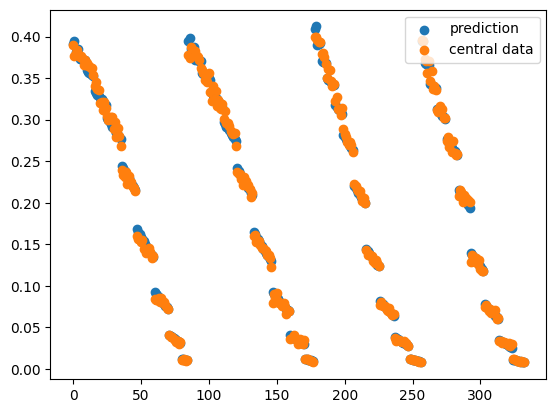

In [9]:
data_name= 'BCDMS_NC_NOTFIXED_P_EM-F2'
fk_exp = fk_table_dict[data_name]
y = central_data_dict[data_name]
fk = padded_fk_dict[data_name]
xgrid_mask = xgrid_masks_dict[data_name]
print(xgrid_mask)
paddedx_fk_table = op.einsum('Xx, nxF -> nXF', xgrid_mask, fk)
predictions = np.einsum('nxf, brxf -> nbr', paddedx_fk_table, output_fk)

ax = plt.subplot()
ax.scatter(np.arange(0 ,predictions.size, 1), predictions.T[0,0,:], label='prediction')
ax.scatter(np.arange(0 ,predictions.size, 1), y, label='central data')
#ax.set_xlim([0,10])
ax.legend()

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

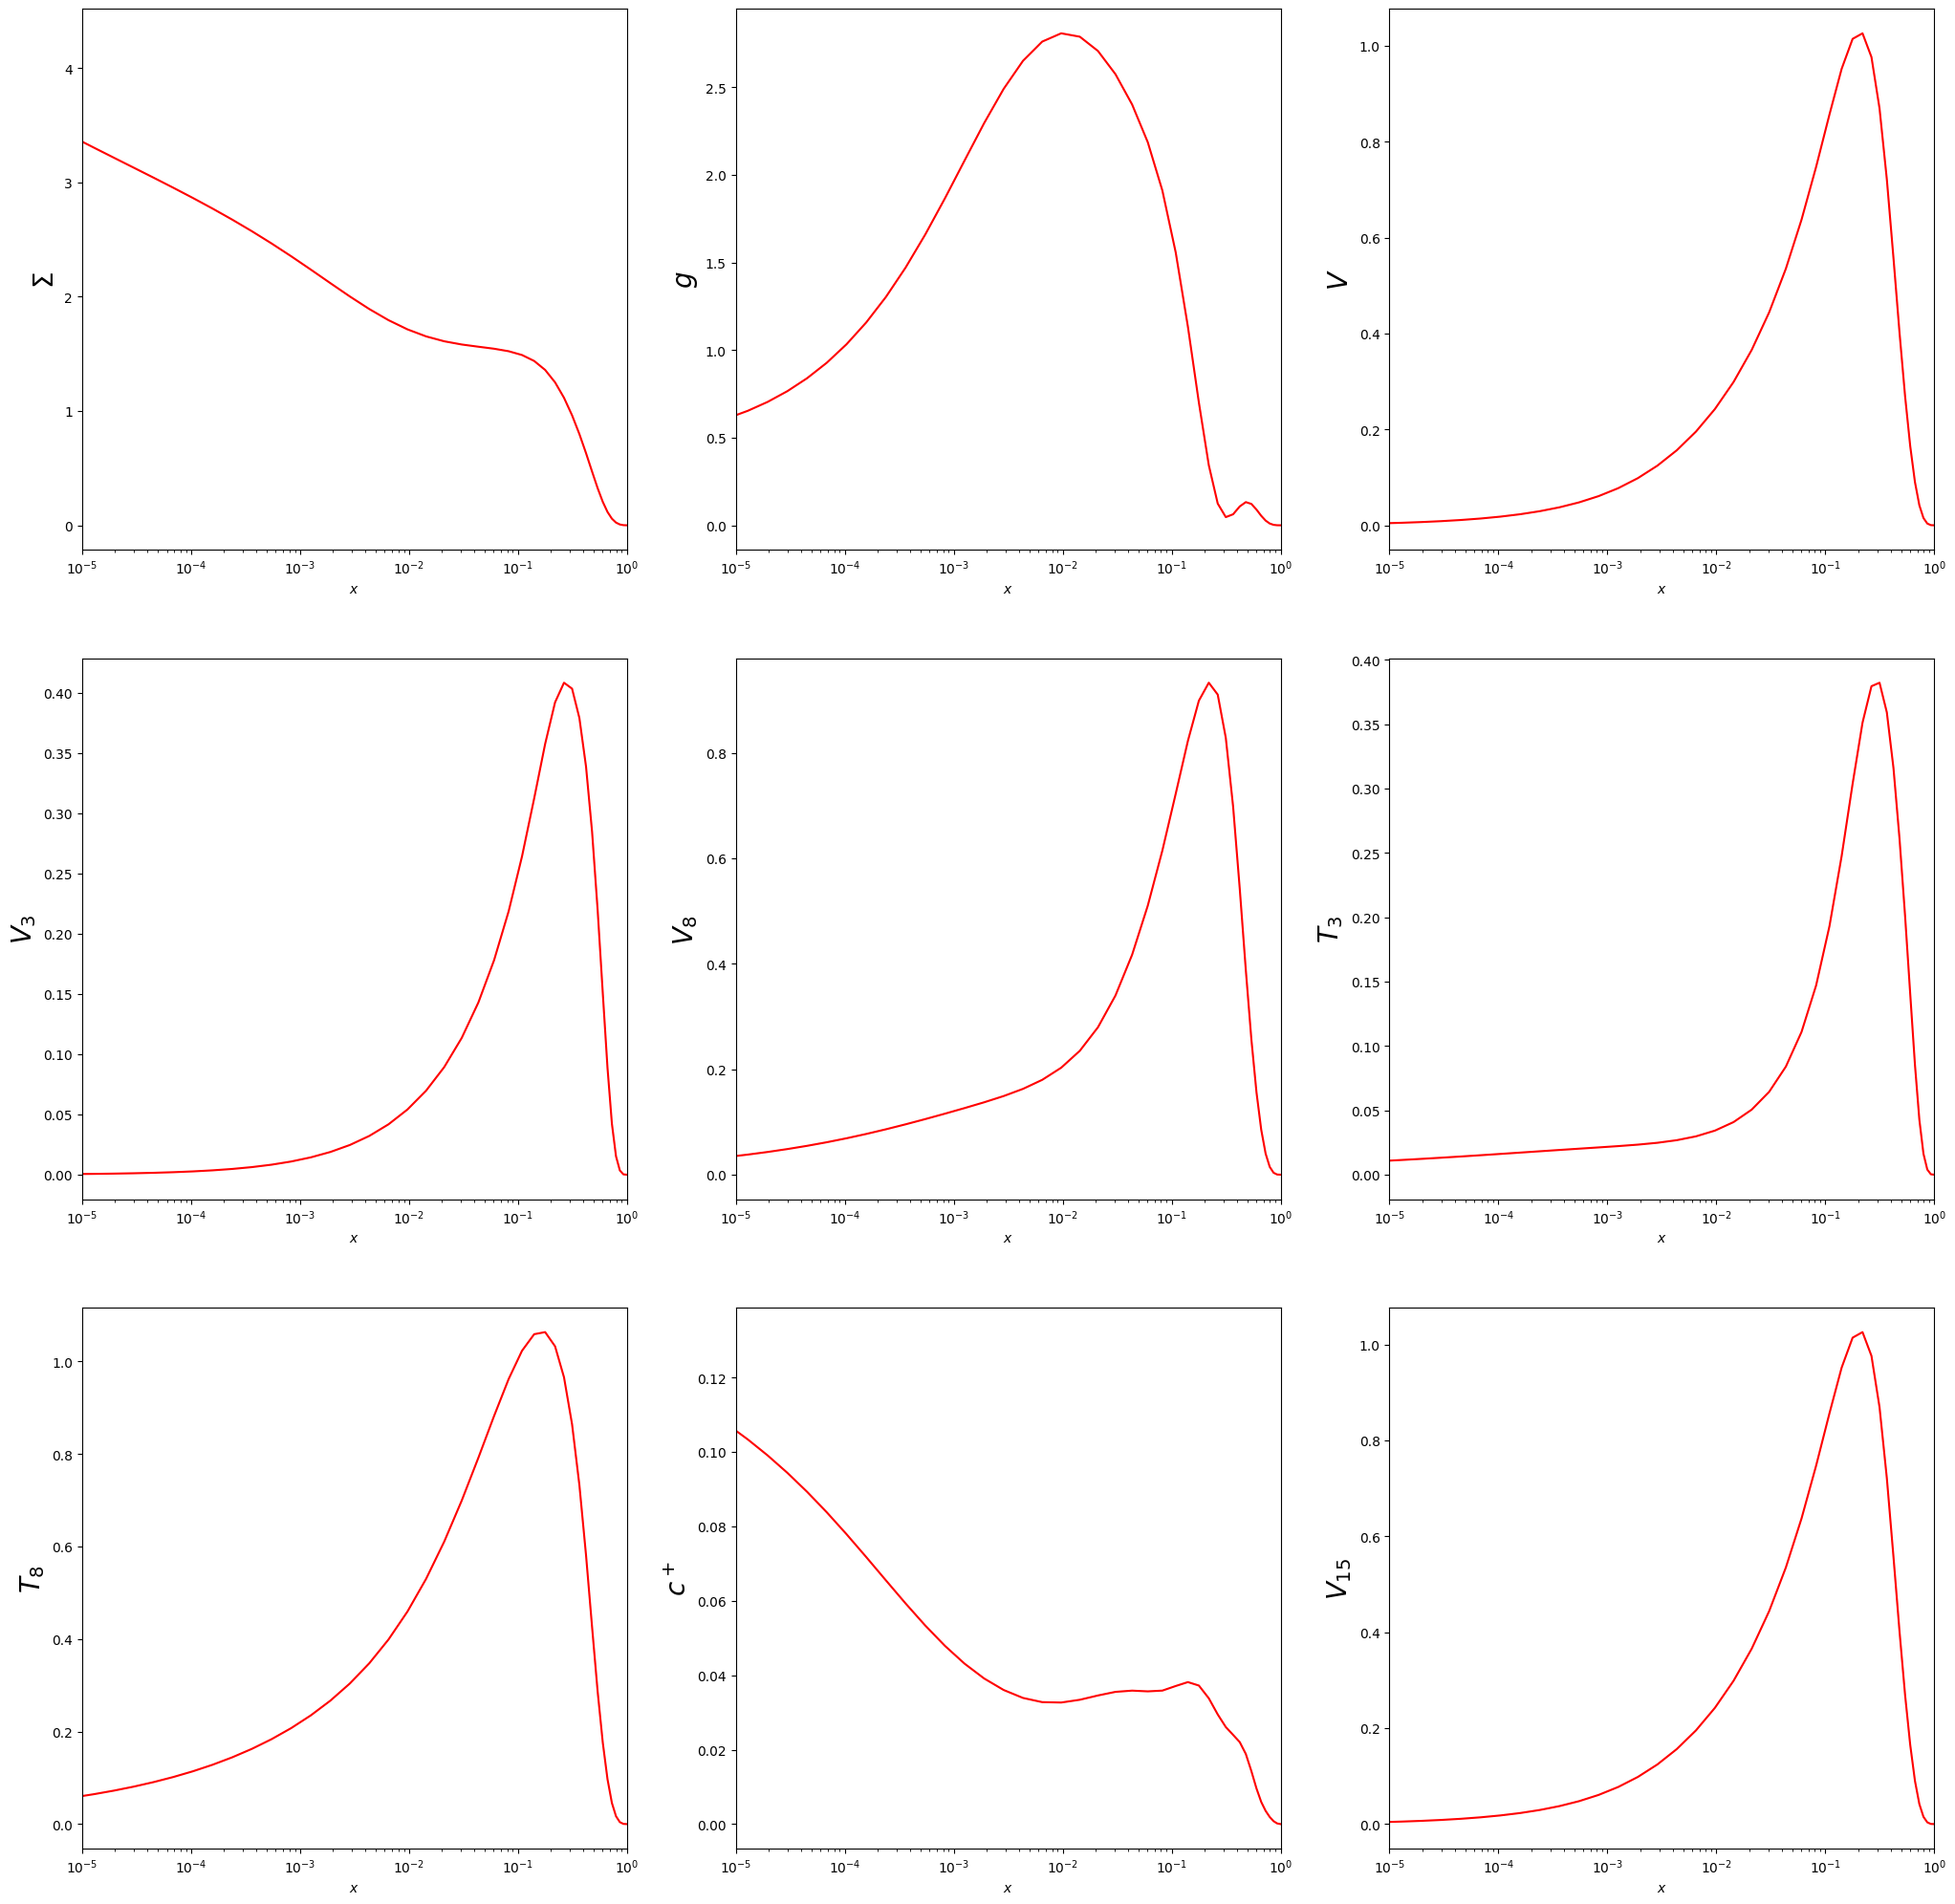

In [10]:
fig, axes = plt.subplots(3, 3, figsize=(25, 25))  # Adjust figsize for desired plot size

for i, ax in enumerate(axes.flatten()):

    ax.plot(XGRID, rotmat(pdf_outs)[0,0,:,i], color='red')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(NN31IC_ev_basis[i], fontsize=20)
    ax.set_xscale('log')
    ax.set_xlim(1e-5,1.)

# Adjust layout to prevent overlapping titles and labels
plt.tight_layout

In [153]:
class ComputeObservable(tf.keras.layers.Layer):
    def __init__(self, fk_dict, **kwargs):
        """
        Custom layer that contracts the output of the neural network with the tensor A.
        A_tf: Tensor of shape (104, 50, 9) that will be used for contraction.
        """
        super(ComputeObservable, self).__init__(**kwargs)
        self.A = fk_dict  # This is the fixed tensor A

    def call(self, f_pred):
        """
        Performs the contraction between f_pred (shape: (50, 9)) and A_tf (shape: (104, 50, 9)).
        f_pred: Output of the neural network (shape: (50, 9)).
        """
        # Expand f_pred to shape (104, 50, 9) so that it can be contracted with A

        # Perform the contraction: sum over the second and third axes
        g = {}
        for exp, fk  in self.A.items():
          g[exp] = tf.einsum('Iia, ia -> I ', fk, f_pred)
        return g

def generate_sequential_model(outputs=1, 
                   input_layer=None, 
                   nlayers=2, 
                   units=[100,100],
                   seed=seed,
                   predictions=False,
                   **kwargs):
  """
  Create a tensorflow sequential model where all intermediate layers have the same size
  This function accepts an already constructed layer as the input.

  All hidden layers will have the same number of nodes for simplicity

  Arguments:
      outputs: int (default=1)
          number of output nodes (how many flavours are we training)
      input_layer: KerasTensor (default=None)
          if given, sets the input layer of the sequential model
      nlayers: int
          number of hidden layers of the network
      units: int
          number of nodes of every hidden layer in the network
      activation: str
          activation function to be used by the hidden layers (ex: 'tanh', 'sigmoid', 'linear')
  """
  if len(units) != nlayers:
      raise Exception("The length of units must match the number of layers.")
  
  if kwargs.get('kernel_initializer'):
      kernel_initializer = kwargs['kernel_initializer']
  else:
      kernel_initializer = tf.keras.initializers.HeNormal

  if kwargs.get('activation_list'):
      activation_list = kwargs['activation_list']
      if len(units) != len(activation_list):
          raise Exception("The length of the activation list must match the number of layers.")
  else:
      activation_list = ['tanh' for _ in range(nlayers)]

  if kwargs.get('output_func'):
      output_func = kwargs['output_func']
  else:
      output_func = 'linear'
  
  if kwargs.get('name'):
      name = kwargs['name']
  else:
      name = 'pdf'
  
  model = tf.keras.models.Sequential(name=name)
  if input_layer is not None:
      model.add(tf.keras.layers.InputLayer(shape=(50,),name='input'))
  for layer in range(nlayers):
      model.add(tf.keras.layers.Dense(units[layer], 
                                      activation=activation_list[layer],
                                      kernel_initializer=kernel_initializer(seed=seed - layer),
                                      ),
      )
  model.add(tf.keras.layers.Dense(outputs, 
                                  activation=output_func, 
                                  kernel_initializer=kernel_initializer(seed=seed - nlayers)
                                  ))
  if predictions:  
    model.add(ComputeObservable(fk_table_dict))

  return model

def compute_ntk(model, input):
  # Record operations for gradient computation
  batch_size = input.size
  n_outputs = model.layers[-1].units
  x = tf.convert_to_tensor(input)
  x = tf.reshape(x, shape=(-1,1))
  with tf.GradientTape(persistent=True) as tape:
      tape.watch(x)
      # Forward pass
      predictions = model(x)

  jacobian = tape.jacobian(predictions, model.trainable_variables)  

  ntk = tf.zeros((n_outputs, batch_size, n_outputs, batch_size))
  for jac in jacobian:
      jac_concat = tf.reshape(jac, (jac.shape[1], jac.shape[0], np.prod(jac.shape[2:]))) 
      ntk += tf.einsum('iap,jbp->iajb', jac_concat, jac_concat)  
  return ntk

In [13]:
C_sys = API.dataset_inputs_t0_covmat_from_systematics(**common_dict)
C = API.groups_covmat_no_table(**common_dict)
C_index = C.index
C_col = C.columns
#C = pd.DataFrame(C_sys, index=C_index, columns=C_col)
#C = pd.DataFrame(np.identity(C.shape[0]), index=C_index, columns=C_col)
Cinv = np.linalg.inv(C)
Cinv = pd.DataFrame(Cinv, index=C_index, columns=C_col)

L = np.linalg.cholesky(Cinv)

LHAPDF 6.5.4 loading /opt/homebrew/Caskroom/miniconda/base/envs/nnpdf_doc/share/LHAPDF/NNPDF40_nnlo_as_01180/NNPDF40_nnlo_as_01180_0000.dat
NNPDF40_nnlo_as_01180 PDF set, member #0, version 1; LHAPDF ID = 331100


## Define loss function to train the model

In [154]:
X = tf.convert_to_tensor(XGRID)
X = tf.reshape(X, shape=(-1,1))

nnpdf_w_preds = generate_sequential_model(outputs=9, nlayers=2, units=[28, 20],seed=seed, name='NNPDF', kernel_initializer=tf.keras.initializers.GlorotNormal, predictions=True)

# Define optimizer
learning_rate = 0.0000005
optimizer = tf.optimizers.SGD(learning_rate=learning_rate )
custom_optimizer = False
predictions_in_time = []

for step in range(1000):  # Number of epochs/iterations
  with tf.GradientTape(persistent=False) as tape:
      # Forward pass: Compute predictions
      predictions = nnpdf_w_preds(X)
      #preds = [pred for pred in predictions.values()]

      loss = 0
      for exp, pred in predictions.items():
        Cinv_exp = tf.convert_to_tensor(Cinv.xs(level="dataset", key=exp).T.xs(level="dataset", key=exp).to_numpy(), name=f'Cinv_{exp}', dtype='float32')
        R = tf.convert_to_tensor(pred - np.array(central_data_dict[exp]), name=f'residue_{exp}', dtype='float32')
        Cinv_R = tf.linalg.matvec(Cinv_exp, R)
        loss += 0.5 * tf.reduce_sum(tf.multiply(R, Cinv_R))

      gradients = tape.gradient(loss, nnpdf_w_preds.trainable_variables)

      if custom_optimizer:
        for grad, weight in zip(gradients, nnpdf_w_preds.weights):
          new_weights = weight.value - learning_rate * grad
          weight.assign(new_weights)
      else:
        optimizer.apply_gradients(zip(gradients, nnpdf_w_preds.trainable_variables))

      if step % 100 == 0:
        print('------------------------')
        print(f"Step {step}, Loss: {loss.numpy()}")

  pdf_from_model = tf.keras.models.Sequential(nnpdf_w_preds.layers[:-1])
  predictions_in_time.append(pdf_from_model(X))

------------------------
Step 0, Loss: 166351.09375
------------------------
Step 100, Loss: 17515.615234375
------------------------
Step 200, Loss: 15646.07421875
------------------------
Step 300, Loss: 16718.646484375
------------------------
Step 400, Loss: 14926.837890625
------------------------
Step 500, Loss: 13705.7568359375
------------------------
Step 600, Loss: 12750.986328125
------------------------
Step 700, Loss: 11937.0185546875
------------------------
Step 800, Loss: 11186.158203125
------------------------
Step 900, Loss: 10461.23046875


### Compute NTK

In [247]:
nnpdf = generate_sequential_model(outputs=9, nlayers=2, units=[28, 20],seed=151316, name='NNPDF', kernel_initializer=tf.keras.initializers.GlorotNormal, predictions=False)
NTK = compute_ntk(nnpdf, XGRID).numpy()
NTK = NTK.reshape((NTK.shape[0] * NTK.shape[1], NTK.shape[2] * NTK.shape[3]))

### Compute and regularise matrix $ M = (FK)^{T} C_{Y}^{-1} (FK)$.

In [248]:
M = np.zeros((50, 9, 50, 9))
for exp, fk in fk_table_dict.items():
  Cinv_red = Cinv.xs(level='dataset', key=exp).T.xs(level='dataset', key=exp)
  #R_fk = np.einsum('fF, nxF -> nxf', R, fk) 
  aux = np.einsum('Ixf, IJ -> xfJ', fk, Cinv_red)
  M += np.einsum('xfI, IXF -> xfXF', aux, fk)

oldshape = M.shape
prod = 1
invshape = oldshape[2:] + oldshape[:2]
for k in oldshape[2:]:
    prod *= k
M = M.reshape(prod, -1)

In [249]:
eta_id = 0.001
Mr = M + eta_id * np.identity(M.shape[0])
M_inv = np.linalg.inv(Mr)
M_inv = M_inv.reshape(*oldshape)

### Compute the matrix that governs the evolution $H = \Theta M$

In [250]:
# Compute the matrix that controls the evolution
H = NTK @ Mr

### Compute the normalisation $K = M_R^{-1} A^T C_Y^{-1} y$

In [251]:
# Construct dataframe for predictions
Y = pd.DataFrame(np.zeros(Cinv.shape[0]), index=Cinv.index)
for exp_name, data in central_data_dict.items():
  if data.size == Y.loc[(slice(None), [exp_name], slice(None)), :].size:
    Y.loc[(slice(None), [exp_name], slice(None)), :] = data
  else:
    raise ValueError

In [252]:
Cinv_Y = Cinv @ Y

# Check
Y_test = C @ Cinv_Y
tmp = Y_test - Y
np.allclose(tmp, np.zeros_like(tmp), rtol=1e-10)

True

In [253]:
FK_Cinv_y = np.zeros((50,9))
for exp, fk in fk_table_dict.items():
  Cinv_Y_red = Cinv_Y.xs(level='dataset', key=exp).to_numpy()
  #R_fk = np.einsum('fF, nxF -> nxf', R, fk)
  FK_Cinv_y += np.einsum('Ixf, I -> xf', fk, Cinv_Y_red[:,0])

K = np.einsum('xfXF , XF -> xf', M_inv, FK_Cinv_y)


### Tests

In [254]:
# Test
Mr = Mr.reshape(oldshape)
M = M.reshape(oldshape)
M_K = np.einsum('xfXF, XF -> xf', Mr, K)

print(np.allclose(M_K, FK_Cinv_y, rtol=1e-4))

for x in range(M_K.shape[0]):
  for f in range(M_K.shape[1]):
    try:
      assert(np.allclose(M_K[x,f], FK_Cinv_y[x,f], rtol=1e-4))
    except AssertionError:
      print(f'Difference at x={x}, f={f} : {M_K[x,f]} != {FK_Cinv_y[x,f]}')

False
Difference at x=14, f=2 : 0.0019490370181045602 != 0.0019485021451941496
Difference at x=15, f=5 : 0.0036738375958521585 != 0.003673340017996911


### Plot predictions at infinity ($K$) of the integrated solutions against data

In [255]:
# Test
dname = data_name #'NMC_NC_NOTFIXED_P_EM-SIGMARED'
fk_table = fk_table_dict[dname]
#K_R = np.einsum('fF, nxF -> nxf', R, fk_table)
infinite_theory_predictions = np.einsum('Ixf, xf -> I', fk_table, K)
print(np.allclose(infinite_theory_predictions, Y.xs(level='dataset', key=dname).to_numpy().T, rtol=1e-3))

False


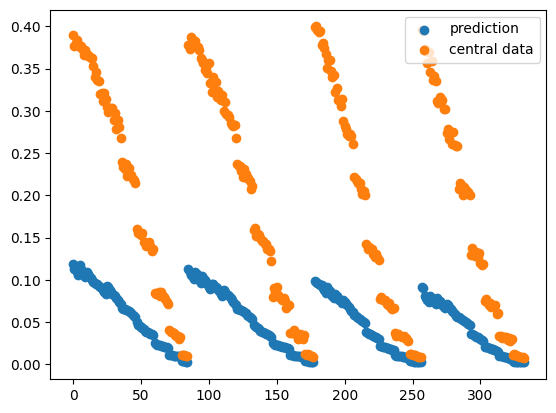

In [256]:
ax = plt.subplot()
ax.scatter(np.arange(0 ,infinite_theory_predictions.size, 1), infinite_theory_predictions, label='prediction')
ax.scatter(np.arange(0 ,infinite_theory_predictions.size, 1), Y.xs(level='dataset', key=dname).to_numpy().T, label='central data')
#ax.set_xlim([0,10])
ax.legend()

### Plot PDFs at infinity ($K$) of the integrated solutions against data

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

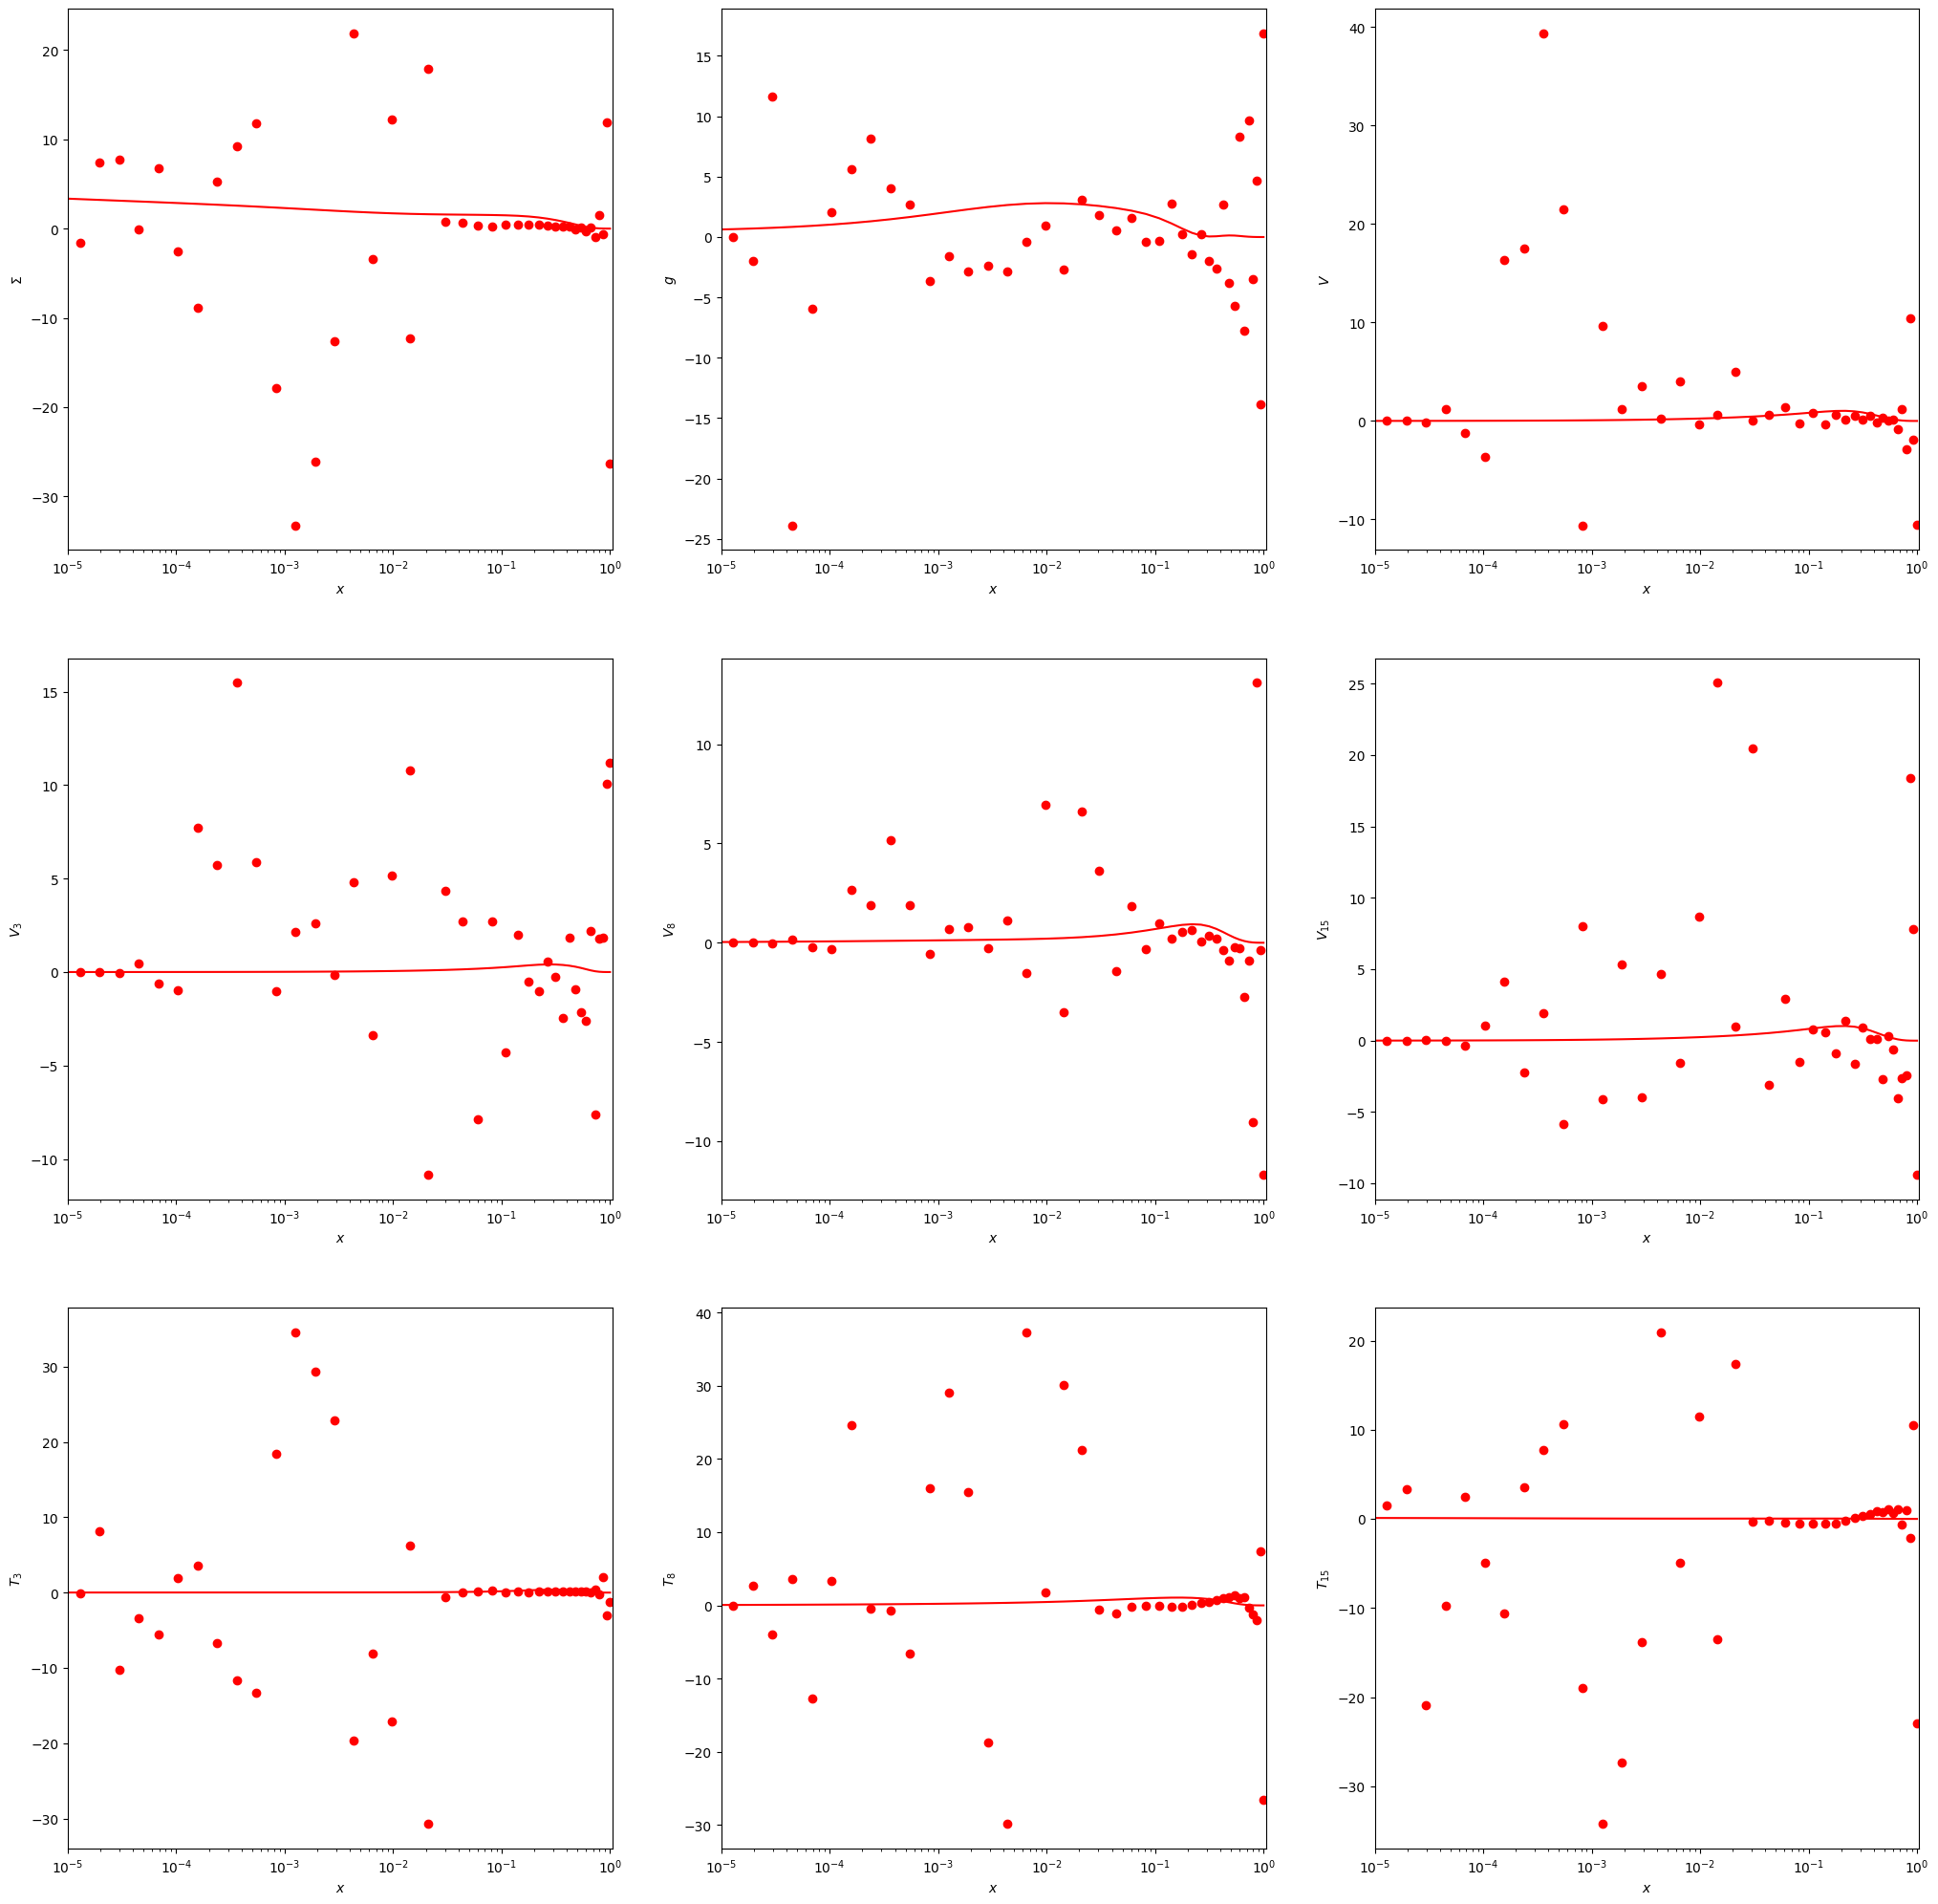

In [257]:
fig, axes = plt.subplots(3, 3, figsize=(25, 25))  # Adjust figsize for desired plot size


for i, ax in enumerate(axes.flatten()):

    ax.scatter(XGRID, K[:,i], color='red')
    ax.plot(XGRID, rotmat(pdf_outs)[0,0,:,conversion_map[i]], color='red')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(evolution_labels[i])
    ax.set_xscale('log')
    ax.set_xlim(1e-5,1.05)

# Adjust layout to prevent overlapping titles and labels
plt.tight_layout

### Integrated PDF as function of the training time t

In [258]:
f0 = nnpdf(XGRID).numpy()

In [261]:
f0[:,6]

array([-6.54350600e-08, -9.92749705e-08, -1.50615193e-07, -2.28506053e-07,
       -3.46678036e-07, -5.25962264e-07, -7.97961889e-07, -1.21062328e-06,
       -1.83668283e-06, -2.78648872e-06, -4.22743642e-06, -6.41345468e-06,
       -9.72970065e-06, -1.47603087e-05, -2.23910429e-05, -3.39646322e-05,
       -5.15157371e-05, -7.81254785e-05, -1.18455289e-04, -1.79547118e-04,
       -2.72015779e-04, -4.11808753e-04, -6.22765860e-04, -9.40257276e-04,
       -1.41617516e-03, -2.12538801e-03, -3.17329029e-03, -4.70305188e-03,
       -6.89950492e-03, -9.98482667e-03, -1.42011847e-02, -1.97791941e-02,
       -2.68992931e-02, -3.56599838e-02, -4.60651368e-02, -5.80330379e-02,
       -7.14190677e-02, -8.60415027e-02, -1.01703107e-01, -1.18205935e-01,
       -1.35360494e-01, -1.52990267e-01, -1.70933753e-01, -1.89045355e-01,
       -2.07194984e-01, -2.25268051e-01, -2.43164375e-01, -2.60797590e-01,
       -2.78095067e-01, -2.94995844e-01], dtype=float32)

In [284]:
eigvals, eigvecs = np.linalg.eig(H)
eigvals = eigvals.real
eigvecs = eigvecs.real

def integrate_flow_t(t, eigvals=eigvals, eigvecs=eigvecs):
  f0_flatten = f0.flatten()#f0.reshape(prod,-1)[:,0]
  K_flatten = K.flatten()#K.reshape(prod,-1)[:,0]
  print(f0_flatten)

  f0_tilde = [np.dot(f0_flatten, eigvecs[:, k]) for k in range(eigvals.size)]
  K_tilde = [np.dot(K_flatten, eigvecs[:, k]) for k in range(eigvals.size)]

  output = np.zeros(shape=K_flatten.shape[0])
  print("___________________")
  for k in range(len(eigvals)):
      C1_k = f0_tilde[k] * np.exp(- eigvals[k] * learning_rate * t)
      C2_k = (1.0 - np.exp(- eigvals[k] * learning_rate * t) ) * K_tilde[k]
      print(f"exp {np.exp(- eigvals[k] * learning_rate * t)}")
      print(f"C1 {C1_k}")
      print(f"C2 {C2_k}")
      output = np.add(output, (C1_k + C2_k) * eigvecs[:,k])
  print("___________________")

  return output

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

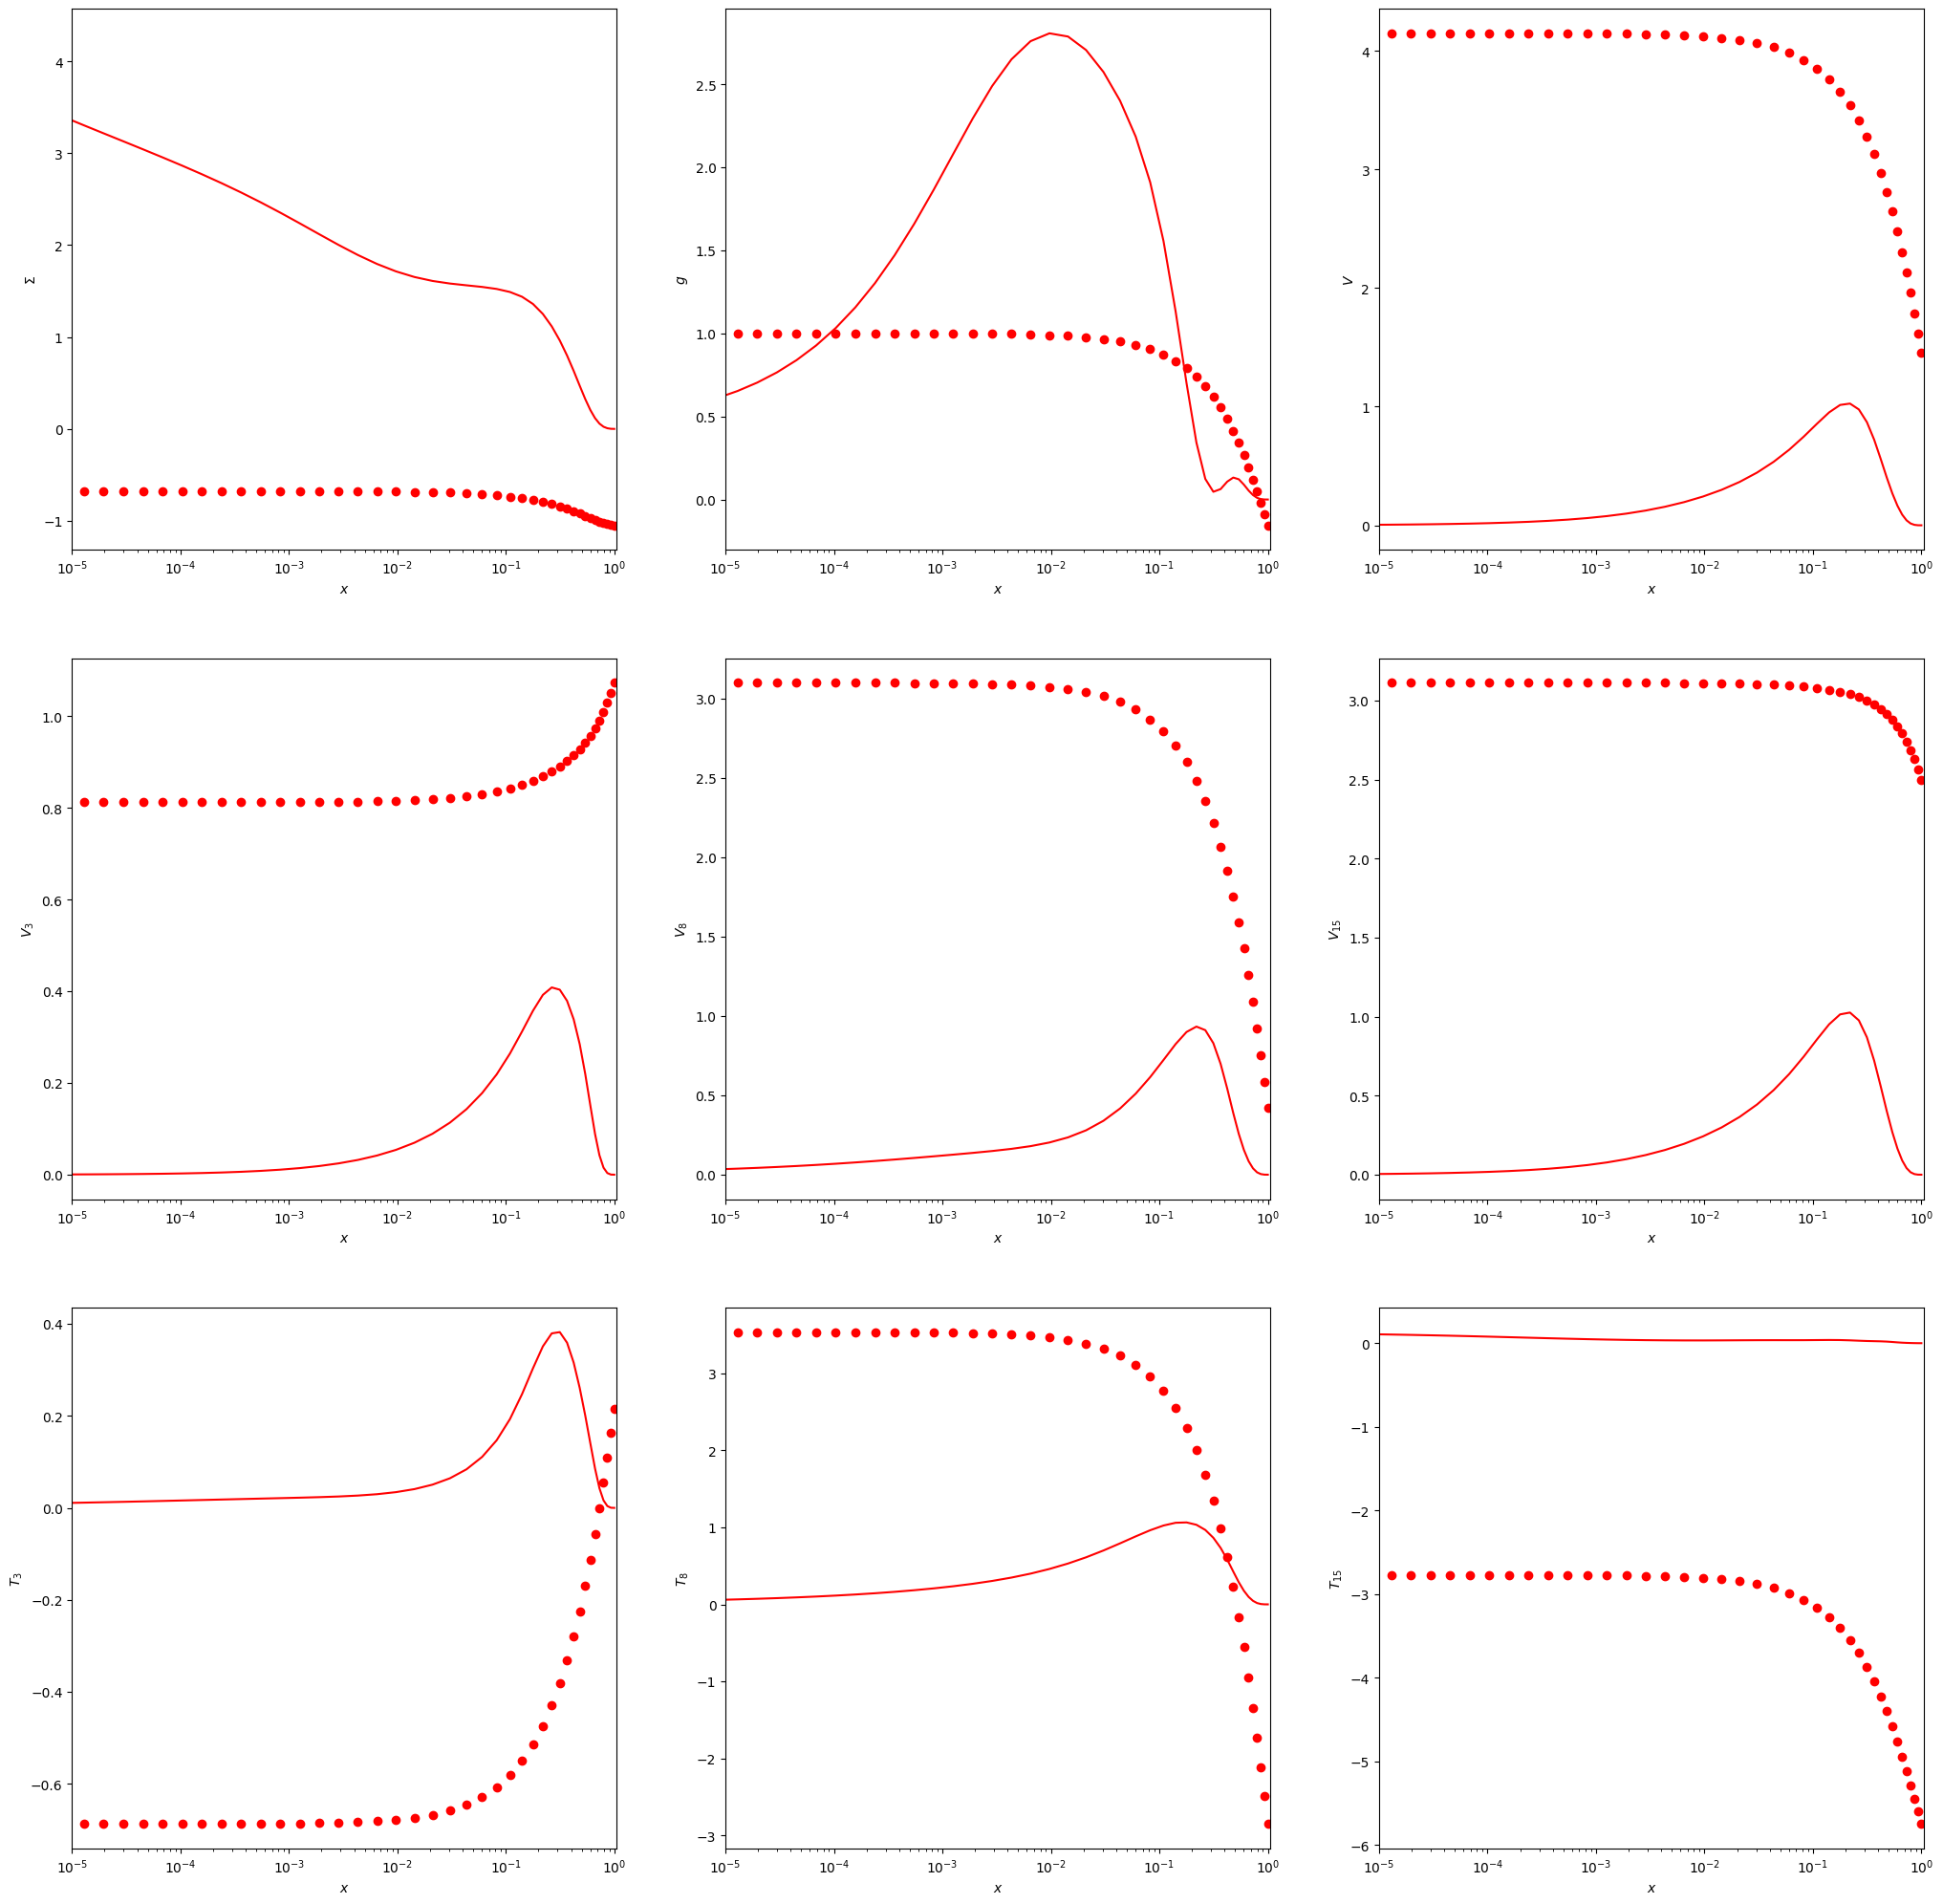

In [213]:
from scipy import interpolate as scint
fig, axes = plt.subplots(3, 3, figsize=(25, 25))  # Adjust figsize for desired plot size


t = 10000000
f_integrated = integrate_flow_t(t)
f_integrated = f_integrated.reshape(oldshape[:2])

for i, ax in enumerate(axes.flatten()):

    ax.scatter(XGRID, f_integrated[:,i], color='red')
    ax.plot(XGRID, rotmat(pdf_outs)[0,0,:,conversion_map[i]], color='red')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(evolution_labels[i])
    ax.set_xscale('log')
    ax.set_xlim(1e-5,1.05)

# Adjust layout to prevent overlapping titles and labels
plt.tight_layout

### Integrated solution as Keras model

In [280]:
# Define the layer that integrate the solution
class IntegratedLayer(tf.keras.layers.Layer):
    def __init__(self, H, f_0, K, **kwargs):
        super(IntegratedLayer, self).__init__(**kwargs)
        self.H = H
        self.original_shape = f_0.shape

        self.f0 = f0.flatten()
        self.K = K.flatten()

        eigvals, eigvecs = np.linalg.eig(H)
        self.eigvals = eigvals.real
        self.eigvecs = eigvecs.real

        self.f0_tilde = [np.dot(self.f0, self.eigvecs[:, k]) for k in range(eigvals.size)]
        self.K_tilde = [np.dot(self.K, self.eigvecs[:, k]) for k in range(eigvals.size)]
    
    def call(self, input):
        input = input[0]
        output = integrate_flow_t(input, eigvals=self.eigvals, eigvecs=self.eigvecs)

        output = output.reshape(self.original_shape)
        return output

# Initialise the model
integrated_preds = tf.keras.Sequential(name='Integrated pdf')
integrated_preds.add(IntegratedLayer(H, f0, K))
#integrated_preds.add(ComputeObservable(fk_table_dict))

In [285]:
t = 0.0
integrated_preds(np.array([t]))[:,6]

[ 8.59658087e-08  1.30420034e-07  7.71289308e-08  1.29579945e-07
 -1.44570267e-08 -2.69879887e-08 -6.54350600e-08  1.06296362e-07
  8.28513578e-08  1.30423189e-07  1.97867053e-07  1.17016363e-07
  1.96592481e-07 -2.19335146e-08 -4.09448937e-08 -9.92749705e-08
  1.61267721e-07  1.25698136e-07  1.97871813e-07  3.00194387e-07
  1.77531547e-07  2.98260687e-07 -3.32764891e-08 -6.21195966e-08
 -1.50615193e-07  2.44667689e-07  1.90703176e-07  3.00201549e-07
  4.55440357e-07  2.69342195e-07  4.52506555e-07 -5.04854683e-08
 -9.42448679e-08 -2.28506053e-07  3.71197956e-07  2.89325584e-07
  4.55450788e-07  6.90971603e-07  4.08632843e-07  6.86520650e-07
 -7.65939561e-08 -1.42983623e-07 -3.46678036e-07  5.63163155e-07
  4.38950480e-07  6.90986781e-07  1.04830679e-06  6.19956666e-07
  1.04155413e-06 -1.16204546e-07 -2.16927489e-07 -5.25962264e-07
  8.54402344e-07  6.65953166e-07  1.04832827e-06  1.59043532e-06
  9.40565599e-07  1.58019031e-06 -1.76299267e-07 -3.29110691e-07
 -7.97961889e-07  1.29625

array([-0.21616246, -0.34154533, -0.33557247, -0.29828275, -0.22889726,
       -0.21496908, -0.18700131, -0.17776573, -0.25137368, -0.24244791,
       -0.24092944, -0.17468085, -0.22939446, -0.34647906, -0.30960382,
       -0.14057572, -0.26848312, -0.25529195, -0.27480984, -0.10264513,
       -0.1919521 , -0.30883678, -0.30702423, -0.09258966, -0.14122989,
       -0.16588016, -0.29644231, -0.18239333, -0.1773547 , -0.04108137,
       -0.23523026, -0.06044951, -0.06063624,  0.03377473, -0.1168083 ,
       -0.03492257, -0.00440381, -0.06005836, -0.04757293, -0.07365935,
       -0.02645382, -0.02779884, -0.03335447, -0.00906922, -0.12428574,
       -0.04542448, -0.13202324, -0.28456883, -0.46193941, -0.59628913])

In [276]:
f_integrated = integrate_flow_t(t)
f_integrated = f_integrated.reshape(oldshape[:2])
f_integrated[:,6]

array([-0.21616246, -0.34154533, -0.33557247, -0.29828275, -0.22889726,
       -0.21496908, -0.18700131, -0.17776573, -0.25137368, -0.24244791,
       -0.24092944, -0.17468085, -0.22939446, -0.34647906, -0.30960382,
       -0.14057572, -0.26848312, -0.25529195, -0.27480984, -0.10264513,
       -0.1919521 , -0.30883678, -0.30702423, -0.09258966, -0.14122989,
       -0.16588016, -0.29644231, -0.18239333, -0.1773547 , -0.04108137,
       -0.23523026, -0.06044951, -0.06063624,  0.03377473, -0.1168083 ,
       -0.03492257, -0.00440381, -0.06005836, -0.04757293, -0.07365935,
       -0.02645382, -0.02779884, -0.03335447, -0.00906922, -0.12428574,
       -0.04542448, -0.13202324, -0.28456883, -0.46193941, -0.59628913])

In [278]:
f0[:,0]

array([8.59658087e-08, 1.30423189e-07, 1.97871813e-07, 3.00201549e-07,
       4.55450788e-07, 6.90986781e-07, 1.04832827e-06, 1.59046465e-06,
       2.41295515e-06, 3.66076961e-06, 5.55382621e-06, 8.42572445e-06,
       1.27824642e-05, 1.93914657e-05, 2.94163929e-05, 4.46212798e-05,
       6.76791678e-05, 1.02637925e-04, 1.55621514e-04, 2.35881322e-04,
       3.57362733e-04, 5.41016809e-04, 8.18163098e-04, 1.23527006e-03,
       1.86051033e-03, 2.79224291e-03, 4.16893093e-03, 6.17866404e-03,
       9.06425808e-03, 1.31175816e-02, 1.86567437e-02, 2.59845927e-02,
       3.53379920e-02, 4.68458422e-02, 6.05125502e-02, 7.62295350e-02,
       9.38052237e-02, 1.12998635e-01, 1.33547962e-01, 1.55190036e-01,
       1.77672118e-01, 2.00758114e-01, 2.24231467e-01, 2.47895852e-01,
       2.71575391e-01, 2.95114040e-01, 3.18374604e-01, 3.41238588e-01,
       3.63604426e-01, 3.85387272e-01], dtype=float32)

In [ ]:
pdf_integrated_in_time = []
for step in range(1000000):
  # Forward pass: Compute predictions
  predictions = integrated_preds(np.array([step]))

  loss = 0
  for exp, pred in predictions.items():
    Cinv_exp = tf.convert_to_tensor(Cinv.xs(level="dataset", key=exp).T.xs(level="dataset", key=exp).to_numpy(), name=f'Cinv_{exp}', dtype='float32')
    R = tf.convert_to_tensor(pred - np.array(central_data_dict[exp]), name=f'residue_{exp}', dtype='float32')
    Cinv_R = tf.linalg.matvec(Cinv_exp, R)
    loss += 0.5 * tf.reduce_sum(tf.multiply(R, Cinv_R))

  if step % 100 == 0:
    print('------------------------')
    print(f"Step {step}, Loss: {loss.numpy()}")

  #pdf_from_integrated_model = tf.keras.models.Sequential(integrated_preds.layers[:-1])
  #pdf_integrated_in_time.append(pdf_from_integrated_model(np.array([step])))

In [267]:
f0.flatten().shape

(450,)